## Background
开始正儿八经学习deep learning了，主要用[keras](https://keras.io/)。当然主要是用，并不准备从理论推导层面掌握得非常透彻，目前主要是当个model.fit, model.prediction来用。图像方面最近在陈兴委的指导下做了两个，第一个做的是Kaggle上的[Human Protein Atlas Image Classification](https://www.kaggle.com/c/human-protein-atlas-image-classification), 然而即使把杨超越女士作为头像后，单个模型成绩也不咋滴。第二个则是cell上的OCT图像数据[^1]，原文是分四类，用了来自imagenet的权重的迁移学习，我DIY了一个，效果也不错；此外，如果只是二分类，分正常和正常的图片，DIY的模型效果好到感觉假，这个数据非常适合入门，记录如下。

----
### 参考文献    

[^1]: Kermany D S, Goldbaum M, Cai W, et al. Identifying medical diagnoses and treatable diseases by image-based deep learning[J]. Cell, 2018, 172(5): 1122-1131. e9.

## 数据准备
我们首先把图片地址与标签一张表格，以“,”分割，大致如下，对于各个标签，像我们这种非专业人士，其实并不知道代表了啥，然而，并不影响建立模型。

| filePath | label |
| -------- | -------- |  
| ./train/NORMAL/NORMAL-8498332-10.jpeg,NORMAL | NORMAL |
| ./train/CNV/CNV-451136-180.jpeg | CNV |
| ./train/DME/DME-462675-38.jpeg | DME |
| ./train/DRUSEN/DRUSEN-5865674-12.jpeg | DRUSEN |
| ... | ... |




先看一下数据大致样子，理论上对于真实数据还要做一些预处理，例如检查图片像素分布，去掉一些不正常的图片等，考虑到这是一篇cell，那就直接开始玩吧，显示图片的时候我们先让他们保持一个大小，当然模型里也是要一个大小的。当然我看了图，也不知道医学上的关键差别在哪儿。

In [45]:
import pylab
import numpy as np
from PIL import Image

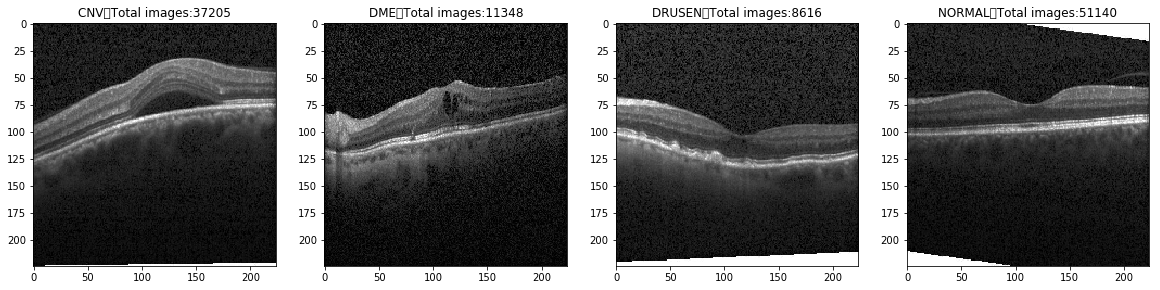

In [46]:
labelf = "/data2/DeepLearning/1.data/kaggle/kang.zhang/data/CellData/OCT/train.csv"
def readImgTest(f):
    img = Image.open(f)
    #转换灰度图
    if img.mode != 'L':
        img = img.convert("L")
    #转换成一个大小，这里我随便设的
    img = np.array(img.resize((224,224)))  
    return img

ds = {}
for i,line in enumerate(open(labelf)):
    if i == 0:
        continue
    line = line.split("\n")[0].split(",")
    ds.setdefault(line[1],[]).append(line[0])
fig,ax = pylab.subplots(1,4,figsize=(20,20))
for i,key in enumerate(ds.keys()):
    ax[i].imshow(readImgTest(ds[key][6]),cmap="gray")
    ax[i].set_title(key+"\tTotal images:%d"%len(ds[key]))
pylab.show()

## 分类模型

开始建立二分类模型，一堆import以及用哪个GPU的设定。

In [47]:
#sys
import os, random
from glob import glob
from copy import deepcopy

#3rd
import h5py
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical, multi_gpu_model
from keras.models import load_model

#specific import
#my code

#global settings for tensorflow
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

确定使用GPU

In [48]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

全局超参，从陈兴委哪儿学来的写法,train_steps应该由图片数量/batch_size得到，多写点少写点没有太大关系。图片大小就是上面随便定的(224,224), 以我有限的资源和来看，图片的大小极大影响了参数的多少，但是还没试过图大点小点对于结果的准确的影响。

In [59]:
# hyperparameters
class hyperparameters:
    num_classes = 2
    batch_size = 256
    learning_rate = 3 * 1e-4
    #last dim is channel
    dims = (224, 224, 1)
    weight_decay = 0.0005
    train_steps = 200
    epochs = 10
PARA = hyperparameters()


读标签。

In [60]:
#read labels from file
def readLabels(f):
    labels = {}
    for i, line in enumerate(open(f)):
        if i == 0:
            continue
        line = line.split("\n")[0].split(",")
        if line[1] == "NORMAL":
            labels[line[0]] = 0
        else:
            labels[line[0]] = 1
    return labels

读图像，简单标准化。

In [61]:
def readPng(f):
    img = Image.open(f)
    if img.mode != 'L':
        img = img.convert("L")
    img = np.array(img.resize((PARA.dims[0],PARA.dims[1]))).reshape(PARA.dims[0], PARA.dims[1], 1) / 255.
    std = np.std(img, ddof=1)
    mean = np.mean(img)
    img = (img - mean) / max(std, 1./PARA.dims[0])
    return img

为内存/GPU memory考虑迭代器。之前转成HDF5文件，其实太多后也有问题，还是这样方便点。

In [62]:
def generator(features, labels, batch_size):
    batch_features = np.zeros((batch_size, PARA.dims[0], PARA.dims[1],
                               PARA.dims[2]))
    batch_labels = np.zeros((batch_size, PARA.num_classes))
    while True:
        for i in range(batch_size):
            index = random.randint(0, len(features) - 1)
            x = readPng(features[index])
            if x is None:
                continue
            y = np.zeros(PARA.num_classes)
            y[labels[index]] = 1
            batch_features[i] = x
            batch_labels[i] = y
        yield batch_features, batch_labels


读取数据和标签

In [63]:
def readXy(f):
    x, y = [], []
    labels = readLabels(f)
    for key, label in list(labels.items()):
        png = key 
        x.append(png)
        y.append(label)
    return x, y

DIY的CNN模型，基本copy了vgg的结构，加了点[batch normalization](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c), 虽说有了batch normaliztion 后可以不加[dropout](https://blog.csdn.net/stdcoutzyx/article/details/49022443),然而我还是加了，没事，大不了训练慢点。 此外，增加卷积层的数量，其实是有助于降低全联接层的参数数量的。最后用的是softmax激活函数，如果是多标签分类，可以使用sigmoid。

In [64]:
def buildModel(blocks=6):
    input_shape = PARA.dims
    model = Sequential()
    #bachnormalization
    model.add(BatchNormalization(name="input_norm", input_shape=input_shape))
    #block 1
    for i in range(blocks):
        #conv/fc -> batchnorm -> activation-> dropout
        model.add(Conv2D(2**(3 + i),(3, 3),padding='same',name="block%s_conv1" % i,))
        model.add(BatchNormalization(name="block%s_norm1" % i))
        model.add(Activation("relu", name="block%s_active1" % i))
        model.add(Conv2D(2**(3 + i),(3, 3),padding='same',name="block%s_conv2" % i,))
        model.add(BatchNormalization(name="block%s_norm2" % i))
        model.add(Activation("relu", name="block%s_active2" % i))
        model.add(Conv2D(2**(3 + i),(3, 3),padding='same',name="block%s_conv3" % i,))
        model.add(BatchNormalization(name="block%s_norm3" % i))
        model.add(Activation("relu", name="block%s_active3" % i))
        model.add(Dropout(0.05, name="block%s_drop" % i))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block%s_pool' % i))
    #flatten and dropout
    model.add(Flatten(name="flatten"))
    model.add(Dense(units=PARA.num_classes ** 3, activation='relu', name="fc1"))
    model.add(Dropout(0.1))
    model.add(Dense(units=PARA.num_classes ** 2, activation='relu', name="fc2"))
    model.add(Dropout(0.1))
    model.add(Dense(units=PARA.num_classes, name="dense_final"))
    #model.add(BatchNormalization(name="dense_norm"))
    model.add(Activation("softmax", name="dense_activation"))
    #mulitple GPU
    #model = multi_gpu_model(model,gpus=PARA.gpus)
    model.compile(
        #loss="binary_crossentropy",  #could run with reduced loss
        loss="categorical_crossentropy", # here not, see multi-labels vs multi-classes,https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/51602
        optimizer=Adam(lr=PARA.learning_rate),
        metrics=['accuracy'],
    )
    return model

显示一下模型，可以用文字在终端显示。

In [65]:
model = buildModel()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_norm (BatchNormalizati (None, 224, 224, 1)       4         
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 8)       80        
_________________________________________________________________
block0_norm1 (BatchNormaliza (None, 224, 224, 8)       32        
_________________________________________________________________
block0_active1 (Activation)  (None, 224, 224, 8)       0         
_________________________________________________________________
block0_conv2 (Conv2D)        (None, 224, 224, 8)       584       
_________________________________________________________________
block0_norm2 (BatchNormaliza (None, 224, 224, 8)       32        
_________________________________________________________________
block0_active2 (Activation)  (None, 224, 224, 8)       0         
__________

模型也可以保存成图片以便后面查看。

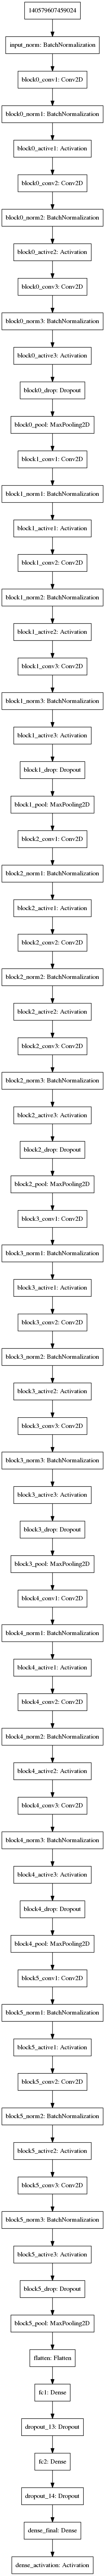

In [66]:
from keras.utils import plot_model
from IPython.display import Image as ipyImage
plot_model(model,"model.png")
ipyImage("model.png")


干一些体力活，例如从train里面切分一些validation以及保存checkpoint。

In [67]:

def getModel(checkpoint=None):
    if os.path.isfile(checkpoint):
        print("loading existing model")
        model = load_model(checkpoint)
    else:
        model = buildModel()    
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",patience=5)
    callbacks = [reduce_lr]
    #print(model.summary())
    if checkpoint is not None:
        cp = ModelCheckpoint(
            checkpoint,
            monitor='val_loss',
            #monitor='val_acc',
            verbose=1,
            save_weights_only=False,
            save_best_only=True,
            mode='min')
            #mode='max')
        callbacks.append(cp)
    return model, callbacks

训练和评估模型，并把训练过程的一些输出保留下来，画图用。

In [74]:
def train_test(pre="test",sufix=""):
    x, y = readXy("/data2/DeepLearning/1.data/kaggle/kang.zhang/data/CellData/OCT/train.csv")
    class_weights = class_weight.compute_class_weight("balanced",np.unique(y),y)
    x_train,x_vali,y_train,y_vali = train_test_split( x,y,test_size=0.1,random_state=123 )
    model, callbacks = getModel("%s_model.h5"%pre)  #category loss
    hist = model.fit_generator(
        generator(x_train, y_train, PARA.batch_size),
        callbacks=callbacks,
        epochs=PARA.epochs,
        steps_per_epoch=PARA.train_steps,
        shuffle=True,
        use_multiprocessing=True,
        class_weight=class_weights,
        validation_data=generator(x_vali, y_vali, PARA.batch_size),
        validation_steps=10)
    hist = pd.DataFrame(hist.history)
    hist.to_csv("%s_%s_trainningHistroy.txt"%(pre,sufix), sep="\t", index_label="epoch")
    print("------\n"*3)
    print("final metrics as following")
    model = load_model(pre+"_model.h5" )
    print("train data")
    m = model.evaluate_generator( generator(x_train, y_train, PARA.batch_size), steps=PARA.train_steps)
    print("keras metrics", model.metrics_names, m)
    print("vali data")
    m = model.evaluate_generator( generator(x_vali, y_vali, PARA.batch_size), steps=5)
    print("keras metrics", model.metrics_names, m)
    print("test data")
    x_test,y_test = readXy("/data2/DeepLearning/1.data/kaggle/kang.zhang/data/CellData/OCT/test.csv")
    m = model.evaluate_generator( generator(x_test, y_test, PARA.batch_size), steps=5)
    print("keras metrics", model.metrics_names, m)


In [69]:
train_test()

Epoch 1/10
200/200 [==============================] - 535s 3s/step - loss: 0.4560 - acc: 0.7256 - val_loss: 0.2383 - val_acc: 0.9156

Epoch 00001: val_loss improved from inf to 0.23825, saving model to test_model.h5
Epoch 2/10
200/200 [==============================] - 387s 2s/step - loss: 0.2984 - acc: 0.8070 - val_loss: 0.2555 - val_acc: 0.9187

Epoch 00002: val_loss did not improve from 0.23825
Epoch 3/10
200/200 [==============================] - 301s 2s/step - loss: 0.2492 - acc: 0.8519 - val_loss: 0.1385 - val_acc: 0.9613

Epoch 00003: val_loss improved from 0.23825 to 0.13850, saving model to test_model.h5
Epoch 4/10
200/200 [==============================] - 244s 1s/step - loss: 0.2356 - acc: 0.9091 - val_loss: 0.1200 - val_acc: 0.9660

Epoch 00004: val_loss improved from 0.13850 to 0.11997, saving model to test_model.h5
Epoch 5/10
200/200 [==============================] - 208s 1s/step - loss: 0.2030 - acc: 0.9399 - val_loss: 0.1279 - val_acc: 0.9664

Epoch 00005: val_loss did

从文章预留的test数据来看，看来模型表现得相当不错，即使我瞎操作为了快点看结果steps也没设对，epoch也比较少。cool，我也敢号称我会deep learning了。画张图看看整体趋势，epoch比较少，画出来也不会很好看，做做样子先。

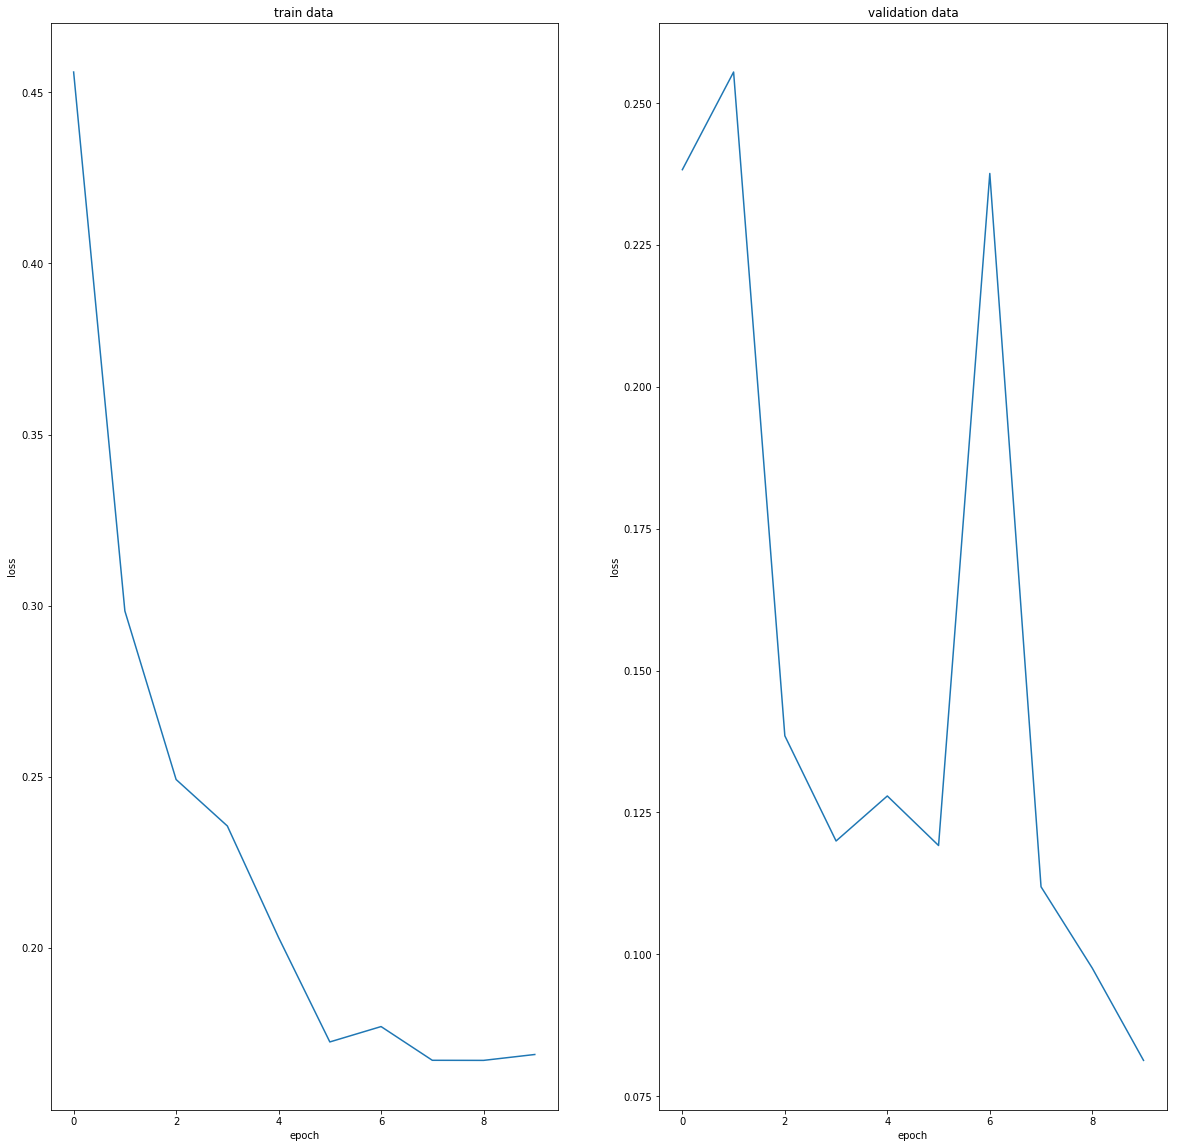

In [76]:
import seaborn as sns 
import pandas as pd
mat = pd.read_table("test_trainningHistroy.txt")
fig,axs = pylab.subplots(1,2,figsize=(20,20))
axs[0].plot(mat.index,mat["loss"])
axs[0].set_title("train data")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[1].plot(mat.index,mat["val_loss"])
axs[1].set_title("validation data")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
pylab.show()

因为保留了model层HDF5格式，改一下steps和epoch可以接着训练。

In [75]:
PARA.train_steps = 400
PARA.epochs = 2
train_test(pre="test",sufix="con1")

loading existing model
Epoch 1/2
400/400 [==============================] - 304s 759ms/step - loss: 0.0860 - acc: 0.9702 - val_loss: 0.1475 - val_acc: 0.9422

Epoch 00001: val_loss improved from inf to 0.14747, saving model to test_model.h5
Epoch 2/2
400/400 [==============================] - 290s 724ms/step - loss: 0.0794 - acc: 0.9718 - val_loss: 0.0988 - val_acc: 0.9707

Epoch 00002: val_loss improved from 0.14747 to 0.09877, saving model to test_model.h5
------
------
------

final metrics as following
train data
('keras metrics', ['loss', 'acc'], [0.20877758170478045, 0.96455078125])
vali data
('keras metrics', ['loss', 'acc'], [0.22562606632709503, 0.96171875])
test data
('keras metrics', ['loss', 'acc'], [0.07091063614934683, 0.99140625])


keras里面继续训练有个问题就是模型里并没有保留上一次训练的val_loss val_acc等等，因而第一个epoch必然会保留新模型（也有可能切的validation数据和上一次训练的不一样的原因），因而最好还是backup一下原来，万一后面的就是没有第一次随手整的好呢。但是这里看train的acc还在上升loss还降，因而还是有进一步把丹练练好的机会的，为了发文章的话，还是值得进一步好好搞的。

## 结论与讨论
这里OCT数据的二分类还可以接着调调模型改进以及进行ensemble得到更好的结果，先歇在这里了。用深度学习跑模型，想要练颗好丹，数据太重要了。